In [1]:
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import math
import tqdm

In [2]:
image = np.asarray(Image.open("mark.png"))
image = np.mean(image, axis=2)

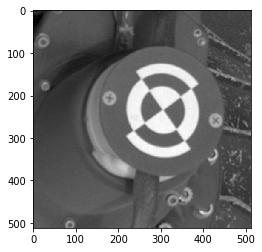

In [3]:
plt.imshow(image, cmap='gray')

In [4]:
gx = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
])

gy = np.array([
    [1,   2,  1],
    [0,   0,  0],
    [-1, -2, -1]
])

In [5]:
gaussian = 1/9 * np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

## Image blur and border detection

In [6]:
def convolve(img, kernel):
    kernel_size = len(kernel)
    sobelled = np.zeros((img.shape[0]-kernel_size-1, img.shape[1]-kernel_size-1))
    for y in range(1, img.shape[0]-kernel_size-1):
        for x in range(1, img.shape[1]-kernel_size-1):
            sobelled[y-1, x-1] = np.sum(np.multiply(img[y-1:y+kernel_size-1, x-1:x+kernel_size-1], kernel))
    return sobelled

In [7]:
def sobel(img):
    s_x = convolve(img, gx)
    s_y = convolve(img, gy)
    return np.sqrt(np.power(s_x, 2) + np.power(s_y, 2))

In [8]:
image = convolve(image, gaussian)

In [9]:
edges = sobel(image).astype(int)

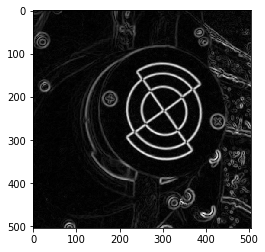

In [10]:
plt.imshow(edges, cmap='gray')

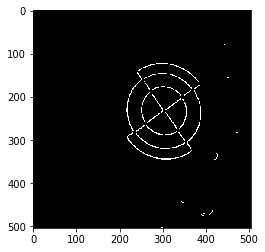

In [11]:
plt.imshow(edges > 170, cmap='gray')

In [12]:
edges = (edges > 170).astype(int)

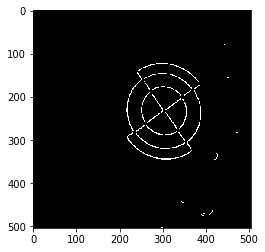

In [13]:
plt.imshow(edges, cmap='gray')

## Hough space

In [14]:
def hough_line(img):
  # Rho and Theta
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    width, height = img.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))  # max_dist
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2.0)

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)
    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img)

    for i in tqdm.tqdm_notebook(range(len(x_idxs))):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            rho = int(round(x * cos_t[t_idx] + y * sin_t[t_idx])) + diag_len
    #         print(rho, t_idx)
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

In [15]:
accumulator, thetas, rhos = hough_line(edges)

/Users/sasha/programming/edu/ucu/computer-vision/.env/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


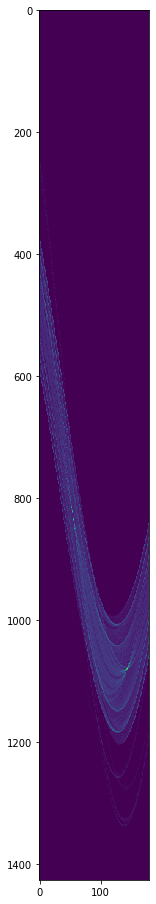

In [16]:
plt.figure(figsize=(8, 16))
plt.imshow(accumulator)

In [17]:
def get_line(theta, rho, limit=505):
    px = []
    py = []
    for x in range(0,500,1):
        m = -math.cos(theta) / math.sin(theta)
        c = rho * 1/math.sin(theta)
        y = m * x + c 
        if x > 0 and x < limit and y > 0 and y < limit:
            px.append(x) 
            py.append(y)
    return (px, py, m, c)

In [18]:
hough_threshold = 100

In [19]:
xs, ys = np.where(accumulator > hough_threshold)

In [20]:
s_rhos = []
s_thetas = []
for idx in range(len(xs)):
    rho = rhos[xs[idx]]
    theta = thetas[ys[idx]]
    s_rhos.append(rho)
    s_thetas.append(theta)
    

In [21]:
def plot(image, s_rhos, s_thetas):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    lines = []
    for idx in range(len(s_rhos)):
        rho = s_rhos[idx]
        theta = s_thetas[idx]
        if math.sin(theta) == 0:
            continue
        px, py, k, b = get_line(theta, rho)
        lines.append((k, b))
        ax.plot(px,py, linewidth=1)
    return lines

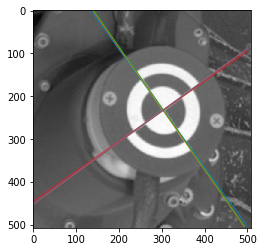

In [22]:
lines = plot(image, s_rhos, s_thetas)

### Result function

In [23]:
image = np.asarray(Image.open("mark.png"))
image = np.mean(image, axis=2)

In [24]:
def get_lines(s_rhos, s_thetas):
    lines = []
    for idx in range(len(s_rhos)):
        rho = s_rhos[idx]
        theta = s_thetas[idx]
        if math.sin(theta) == 0:
            continue
        px, py, k, b = get_line(theta, rho)
        lines.append((k, b))
    return lines

In [25]:
def hough_lines_function(image, edge_threshold=170, hough_threshold=100):
    image = convolve(image, gaussian)
    edges = sobel(image).astype(int)
    edges = (edges > edge_threshold).astype(int)
    accumulator, thetas, rhos = hough_line(edges)
    xs, ys = np.where(accumulator > hough_threshold)
    
    s_rhos = []
    s_thetas = []
    for idx in range(len(xs)):
        rho = rhos[xs[idx]]
        theta = thetas[ys[idx]]
        s_rhos.append(rho)
        s_thetas.append(theta)
    return get_lines(s_rhos, s_thetas)


In [26]:
lines = hough_lines_function(image)

/Users/sasha/programming/edu/ucu/computer-vision/.env/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [27]:
lines

[(1.3763819204711736, -184.72076311443638),
 (1.4281480067421146, -199.7647455779831),
 (1.4281480067421146, -201.50941584503977),
 (-0.7002075382097099, 445.28459889309715),
 (-0.7265425280053611, 452.09988636970036),
 (-0.7265425280053611, 453.3368217633245)]